# GLM: Poisson Regression

In [1]:
## Interactive magics
%matplotlib inline
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import patsy as pt
import pymc3 as pm

plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.3


This is a minimal reproducible example of Poisson regression to predict counts using dummy data.

This Notebook is basically an excuse to demo Poisson regression using PyMC3, both manually and using the `glm` library to demo interactions using the `patsy` library. We will create some dummy data, Poisson distributed according to a linear model, and try to recover the coefficients of that linear model through inference.

For more statistical detail see:

+ Basic info on [Wikipedia](https://en.wikipedia.org/wiki/Poisson_regression)
+ GLMs: Poisson regression, exposure, and overdispersion in Chapter 6.2 of [ARM, Gelmann & Hill 2006](http://www.stat.columbia.edu/%7Egelman/arm/)
+ This worked example from ARM 6.2 by [Clay Ford](http://www.clayford.net/statistics/poisson-regression-ch-6-of-gelman-and-hill/)

This very basic model is inspired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/), which is concerned with understanding the various effects of external environmental factors upon the allergic sneezing of a test subject.


## Local Functions

In [3]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
        
    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in 
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022') 

## Generate Data

This dummy dataset is created to emulate some data created as part of a study into quantified self, and the real data is more complicated than this. Ask Ian Osvald if you'd like to know more https://twitter.com/ianozsvald


### Assumptions:

+ The subject sneezes N times per day, recorded as `nsneeze (int)`
+ The subject may or may not drink alcohol during that day, recorded as `alcohol (boolean)`
+ The subject may or may not take an antihistamine medication during that day, recorded as the negative action `nomeds (boolean)`
+ I postulate (probably incorrectly) that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken, and further increased after alcohol is consumed.
+ The data is aggregated per day, to yield a total count of sneezes on that day, with a boolean flag for alcohol and antihistamine usage, with the big assumption that nsneezes have a direct causal relationship.


Create 4000 days of data: daily counts of sneezes which are Poisson distributed w.r.t alcohol consumption and antihistamine usage

In [4]:
# decide poisson theta values
theta_noalcohol_meds = 1    # no alcohol, took an antihist
theta_alcohol_meds = 3      # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36   # alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_noalcohol_meds, q),
                                   np.random.poisson(theta_alcohol_meds, q),
                                   np.random.poisson(theta_noalcohol_nomeds, q), 
                                   np.random.poisson(theta_alcohol_nomeds, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [5]:
df.tail()

,alcohol,nomeds,nsneeze
3995,True,True,38
3996,True,True,31
3997,True,True,30
3998,True,True,34
3999,True,True,36


##### View means of the various combinations (Poisson mean values)

In [6]:
df.groupby(['alcohol','nomeds']).mean().unstack()

nsneeze        
nomeds    False   True 
alcohol                
False     1.018   5.866
True      2.938  35.889

### Briefly Describe Dataset

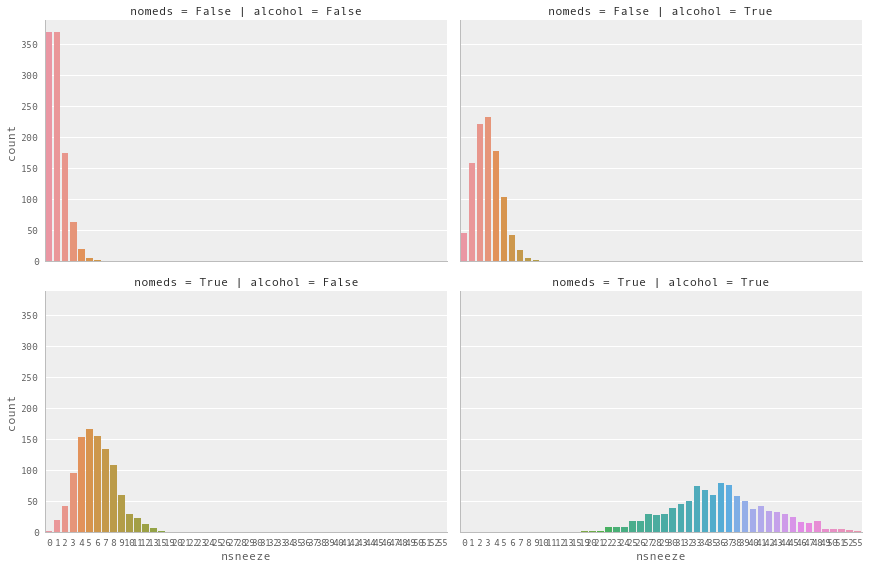

In [7]:
g = sns.factorplot(x='nsneeze', row='nomeds', col='alcohol', data=df,
               kind='count', size=4, aspect=1.5)

**Observe:**

+ This looks a lot like poisson-distributed count data (because it is)
+ With `nomeds == False` and `alcohol == False` (top-left, akak antihistamines WERE used, alcohol was NOT drunk) the mean of the poisson distribution of sneeze counts is low.
+ Changing `alcohol == True` (top-right) increases the sneeze count `nsneeze` slightly
+ Changing `nomeds == True` (lower-left) increases the sneeze count `nsneeze` further
+ Changing both `alcohol == True and nomeds == True` (lower-right) increases the sneeze count `nsneeze` a lot, increasing both the mean and variance.

---

## Poisson Regression

Our model here is a very simple Poisson regression, allowing for interaction of terms:

$$ \theta = exp(\beta X)$$

$$ Y_{sneeze\_count} ~ Poisson(\theta)$$



**Create linear model for interaction of terms**

In [8]:
fml = 'nsneeze ~ alcohol + antihist + alcohol:antihist'  # full patsy formulation

In [9]:
fml = 'nsneeze ~ alcohol * nomeds'  # lazy, alternative patsy formulation

### 1. Manual method, create design matrices and manually specify model

**Create Design Matrices**

In [10]:
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe', NA_action='raise')

In [11]:
pd.concat((mx_ex.head(3),mx_ex.tail(3)))

,Intercept,alcohol[T.True],nomeds[T.True],alcohol[T.True]:nomeds[T.True]
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0
3999,1.0,1.0,1.0,1.0


**Create Model**

In [12]:
with pm.Model() as mdl_fish:
    
    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_alcohol[T.True]', mu=0, sd=10)
    b2 = pm.Normal('b2_nomeds[T.True]', mu=0, sd=10)
    b3 = pm.Normal('b3_alcohol[T.True]:nomeds[T.True]', mu=0, sd=10)
    
    # define linear model and exp link function
    theta = (b0 +
            b1 * mx_ex['alcohol[T.True]'] +
            b2 * mx_ex['nomeds[T.True]'] +
            b3 * mx_ex['alcohol[T.True]:nomeds[T.True]']) 

    ## Define Poisson likelihood 
    y = pm.Poisson('y', mu=np.exp(theta), observed=mx_en['nsneeze'].values)
    

**Sample Model**

In [13]:
with mdl_fish:
    trc_fish = pm.sample(2000, tune=1000, cores=4)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 8,741.9:  17%|█▋        | 33556/200000 [00:07<00:37, 4436.96it/s]
Convergence archived at 34000
Interrupted at 34,000 [17%]: Average Loss = 12,493
100%|██████████| 2000/2000 [00:53<00:00, 37.07it/s]


**View Diagnostics**

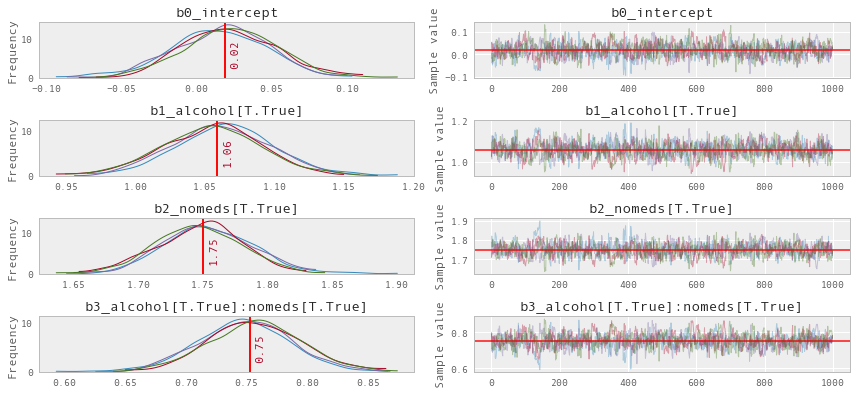

In [14]:
rvs_fish = [rv.name for rv in strip_derived_rvs(mdl_fish.unobserved_RVs)]
plot_traces_pymc(trc_fish, varnames=rvs_fish)

**Observe:**

+ The model converges quickly and traceplots looks pretty well mixed

### Transform coeffs and recover theta values

In [15]:
np.exp(pm.summary(trc_fish, varnames=rvs_fish)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
b0_intercept,1.019115,0.960588,1.084479
b1_alcohol[T.True],2.883167,2.677978,3.083394
b2_nomeds[T.True],5.755584,5.404332,6.166625
b3_alcohol[T.True]:nomeds[T.True],2.122313,1.960857,2.285519


**Observe:**

+ The contributions from each feature as a multiplier of the baseline sneezecount appear to be as per the data generation:
    
    
    1. exp(b0_intercept): mean=1.02  cr=[0.96, 1.08]        
    
        Roughly linear baseline count when no alcohol and meds, as per the generated data: 

        theta_noalcohol_meds = 1 (as set above)
        theta_noalcohol_meds = exp(b0_intercept) 
                             = 1


    2. exp(b1_alcohol): mean=2.88  cr=[2.69, 3.09]
    
        non-zero positive effect of adding alcohol, a ~3x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_alcohol_meds = 3 (as set above)
        theta_alcohol_meds = exp(b0_intercept + b1_alcohol) 
                           = exp(b0_intercept) * exp(b1_alcohol) 
                           = 1 * 3 = 3


    3. exp(b2_nomeds[T.True]): mean=5.76  cr=[5.40, 6.17]    
    
        larger, non-zero positive effect of adding nomeds, a ~6x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_noalcohol_nomeds = 6 (as set above)
        theta_noalcohol_nomeds = exp(b0_intercept + b2_nomeds)
                               = exp(b0_intercept) * exp(b2_nomeds) 
                               = 1 * 6 = 6
    
    
    4. exp(b3_alcohol[T.True]:nomeds[T.True]): mean=2.12  cr=[1.98, 2.30]
    
        small, positive interaction effect of alcohol and meds, a ~2x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_alcohol_nomeds = 36 (as set above)
        theta_alcohol_nomeds = exp(b0_intercept + b1_alcohol + b2_nomeds + b3_alcohol:nomeds)
                             = exp(b0_intercept) * exp(b1_alcohol) * exp(b2_nomeds * b3_alcohol:nomeds)
                             = 1 * 3 * 6 * 2 = 36
   


### 2. Alternative method, using `pymc.glm`

**Create Model**

**Alternative automatic formulation using `pmyc.glm`**

In [16]:
with pm.Model() as mdl_fish_alt:
    
    pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Poisson())

**Sample Model**

In [17]:
with mdl_fish_alt:
    trc_fish_alt = pm.sample(4000, tune=2000)[2000:]

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 8,752.5:  36%|███▋      | 72995/200000 [00:28<00:48, 2645.19it/s]
Convergence archived at 73000
Interrupted at 73,000 [36%]: Average Loss = 10,558
100%|██████████| 4000/4000 [00:59<00:00, 67.09it/s]


**View Traces**

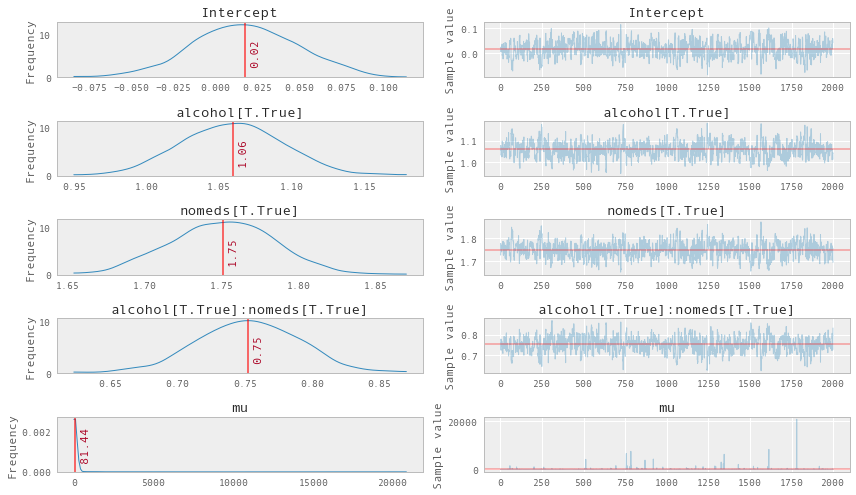

In [18]:
rvs_fish_alt = [rv.name for rv in strip_derived_rvs(mdl_fish_alt.unobserved_RVs)]
plot_traces_pymc(trc_fish_alt, varnames=rvs_fish_alt)

### Transform coeffs

In [19]:
np.exp(pm.summary(trc_fish_alt, varnames=rvs_fish_alt)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
Intercept,1.018166e+00,0.958267,1.081268e+00
alcohol[T.True],2.884562e+00,2.695548,3.099807e+00
nomeds[T.True],5.757993e+00,5.398246,6.140422e+00
alcohol[T.True]:nomeds[T.True],2.122279e+00,1.972142,2.298126e+00
mu,2.328724e+35,1.002232,8.016059e+66


**Observe:**

+ The traceplots look well mixed
+ The transformed model coeffs look moreorless the same as those generated by the manual model
+ Note also that the `mu` coeff is for the overall mean of the dataset and has an extreme skew, if we look at the median value ...

In [20]:
np.percentile(trc_fish_alt['mu'], [25,50,75])

array([  4.04931927,   9.77667856,  23.27432728])

... of 9.45 with a range [25%, 75%] of [4.17, 24.18], we see this is pretty close to the overall mean of:

In [21]:
df['nsneeze'].mean()

11.42775

---
Example originally contributed by Jonathan Sedar 2016-05-15 [github.com/jonsedar](https://github.com/jonsedar)